# 1. Visão geral do notebook
Análise dos dados em 'dados/precos_semestrais_automotivos_2024_02.csv', separando cada produto em um dataframe, tratando os dados, eliminando outliers, mostrando o preço médio por estado com um gráfico e identificando o município de MG com o menor preço da gasolina.

# 2. Bibliotecas

- pandas (https://pandas.pydata.org/docs/): para análise dos dados.
- matplotlib (https://matplotlib.org/stable/api/index): para criação dos gráficos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 3. Importação dos dados

In [2]:
dados = pd.read_csv('dados/precos_semestrais_automotivos_2024_02.csv', sep = ';')

Informações gerais dos dados:

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421382 entries, 0 to 421381
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Regiao - Sigla     421382 non-null  object 
 1   Estado - Sigla     421382 non-null  object 
 2   Municipio          421382 non-null  object 
 3   Revenda            421382 non-null  object 
 4   CNPJ da Revenda    421382 non-null  object 
 5   Nome da Rua        421382 non-null  object 
 6   Numero Rua         421282 non-null  object 
 7   Complemento        94698 non-null   object 
 8   Bairro             420809 non-null  object 
 9   Cep                421382 non-null  object 
 10  Produto            421382 non-null  object 
 11  Data da Coleta     421382 non-null  object 
 12  Valor de Venda     421382 non-null  object 
 13  Valor de Compra    0 non-null       float64
 14  Unidade de Medida  421382 non-null  object 
 15  Bandeira           421382 non-null  object 
dtypes:

# 3. Tratamento inicial

## 3.1. Colunas necessárias

Com base no objetivo de criar um dataframe para cada produto, mostrar o preço médio dos produtos por estado e qual a cidade de MG com o menor preço da gasolina, as colunas necessárias para a análise são: 'Estado - Sigla', 'Municipio', 'Produto' e 'Valor de Venda'.

O valor de venda, ou preço, é dado em R$/litro para todos os produtos, exceto o GNV, que é em R$/m3.

In [4]:
dados = dados[['Estado - Sigla', 'Municipio', 'Produto', 'Valor de Venda']]

Os nomes das colunas também podem ser simplificados:

In [5]:
dados.rename(columns=
             {'Estado - Sigla':'estado',
              'Municipio':'municipio',
              'Produto':'produto',
              'Valor de Venda':'preco'},
              inplace=True)

Resultado mostrando as 5 primeiras linhas do dataframe:

In [6]:
dados.head(5)

,estado,municipio,produto,preco
0,AC,RIO BRANCO,GASOLINA,"6,79"
1,AC,RIO BRANCO,GASOLINA ADITIVADA,"6,84"
2,AC,RIO BRANCO,DIESEL,"6,99"
3,AC,RIO BRANCO,DIESEL S10,"6,99"
4,AC,RIO BRANCO,ETANOL,"4,69"


## 3.2. Tipos de dados

O tipo de dado do preço precisa ser alterado para um tipo numérico.

In [7]:
dados['preco'] = dados['preco'].str.replace(',','.').astype(float)

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421382 entries, 0 to 421381
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   estado     421382 non-null  object 
 1   municipio  421382 non-null  object 
 2   produto    421382 non-null  object 
 3   preco      421382 non-null  float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


# 4. Criando um dataframe por produto

Os produtos são:

In [9]:
lista_de_produtos = dados['produto'].drop_duplicates().to_list()
lista_de_produtos

['GASOLINA', 'GASOLINA ADITIVADA', 'DIESEL', 'DIESEL S10', 'ETANOL', 'GNV']

Criando um dicionário de dataframes. Cada chave do dicionário corresponde a um produto e cujo valor é o dataframe do produto:

In [10]:
produtos = {}
for p in lista_de_produtos:
    produto_nome = p.casefold().replace(' ','_')
    produto_df = dados.query("produto==@p").drop('produto', axis=1).reset_index(drop=True)
    produtos[produto_nome] = produto_df

# 5. Outliers

## 5.1. Considerações sobre os dados

Os dados do LPC (Levantamento de Preços de Combustíveis) são disponibilizados pela ANP (Agência Nacional do Petróleo, Gás Natural e Biocombustíveis). Conforme [informações do portal gov.br](https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/informacoes-levantamento-de-precos-de-combustiveis), o LPC, que é realizado por uma empresa especializada, oferece referências para o mercado, órgãos de governo e a sociedade civil em geral. Neste contexto, é bem provável que os possíveis outliers não se devem a erros na coleta de dados, mas a alguma sazonalidade ou evento atípico.

Pode-se considerar também que existem custos que afetam o preço final do produto e que sao inerentes a cada estado, como diferenças de tributação, infraestrutura logística para abastecimento da região, entre outros. Uma análise dos outliers por estado pode implicar em um resultado mais coerente com a realidade.

## 5.2. Forma de identificação

Uma das formas de identificar os dados discrepantes do conjunto é através de limites superiores e inferiores baseados nos quartis e no intervalo interquartil. Essa também é a forma de determinar os valores para desenhar um gráfico de diagrama de caixa, também conhecido como *boxplot*.

O limite superior (LS) e inferior (LI) são dados por:

- $LS = Q3 + (1.5 * IIQ)$
- $LI = Q1 - (1.5 * IIQ)$

Sendo:

- $Q3$ = Quartil 3;
- $Q1$ = Quartil 1;
- $IIQ$ = Intervalo Interquartil, dado por $(Q3 - Q1)$, também chamado de Amplitude Interquartil ($AIQ$).

Referência: [Wikipedia](https://pt.wikipedia.org/wiki/Amplitude_interquartil)

Um gráfico boxplot tem a seguinte estrutura:

<img src="https://fernandafperes.com.br/blog/interpretacao-boxplot/g2.png" width="559" height="406"/>

Importante destacar que o limite superior (ls) e inferior (li) do gráfico não irão, necessáriamente, coincidir com  LS e LI calculados. Eles serão

- $ls = max(d)$ para todo $d$ pertencente ao conjunto de dados, tal que $d <= LS$.

- $li = min(d)$, para todo $d$ pertencente ao conjunto de dados, tal que $d >= LI$.

Ou seja, o limite superior do gráfico $ls$ será o maior valor que está abaixo de $LS$, ou igual a $LS$, e o limite inferior $li$ será o menor valor que está acima de $LI$, ou igual a $LI$.

## 5.3. Gráfico boxplot dos produtos por estado

Abaixo seguem os gráficos boxplots por estado para cada um dos produtos, fornecendo uma visão gráfica geral dos outliers:

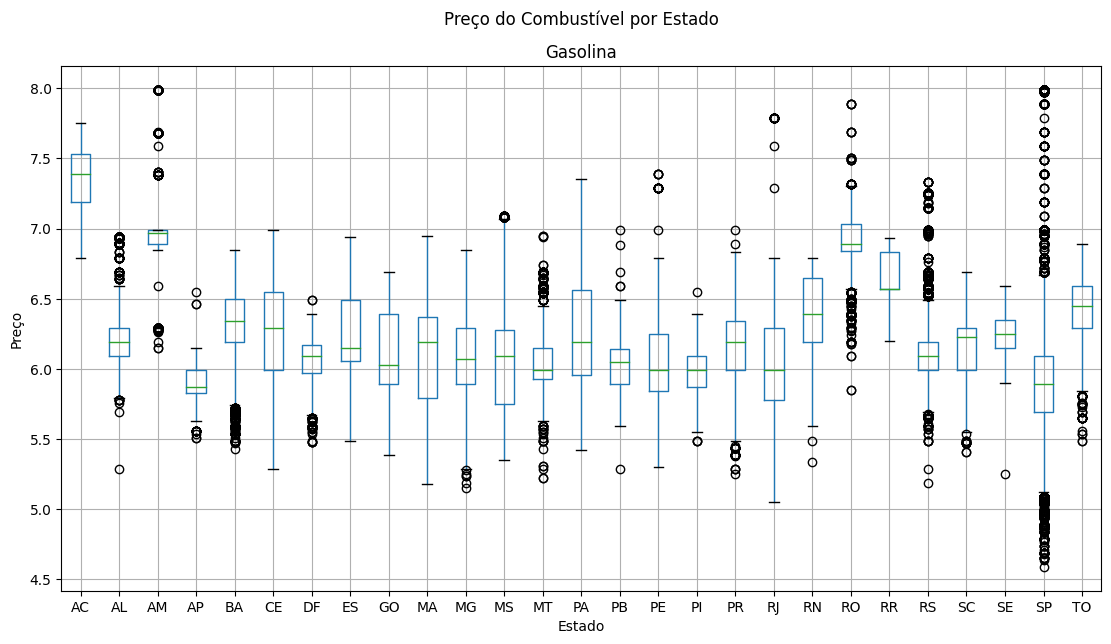

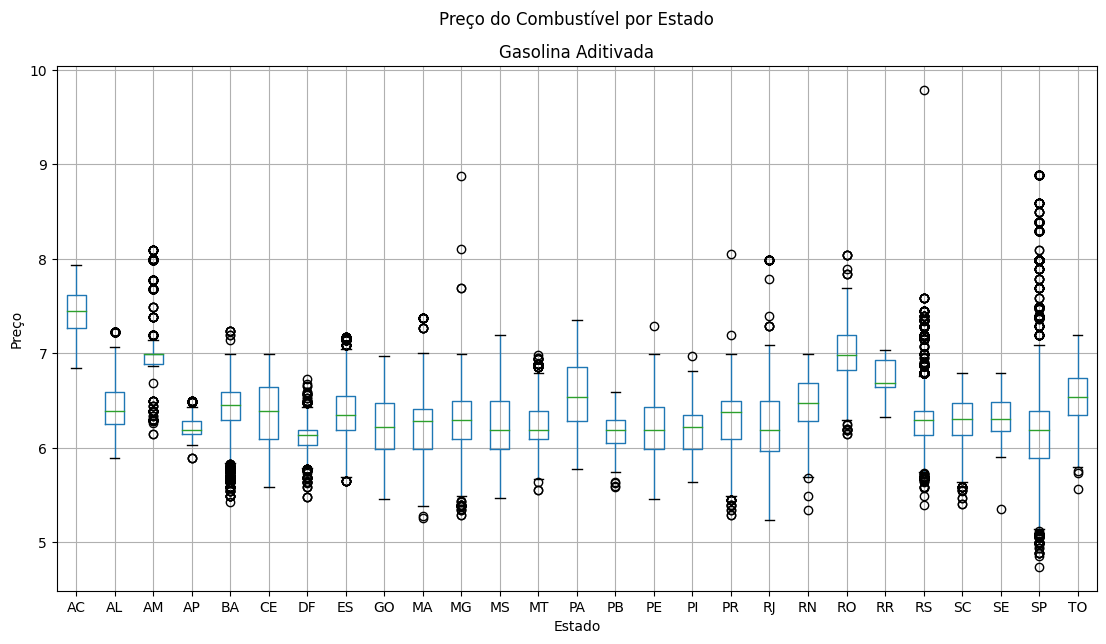

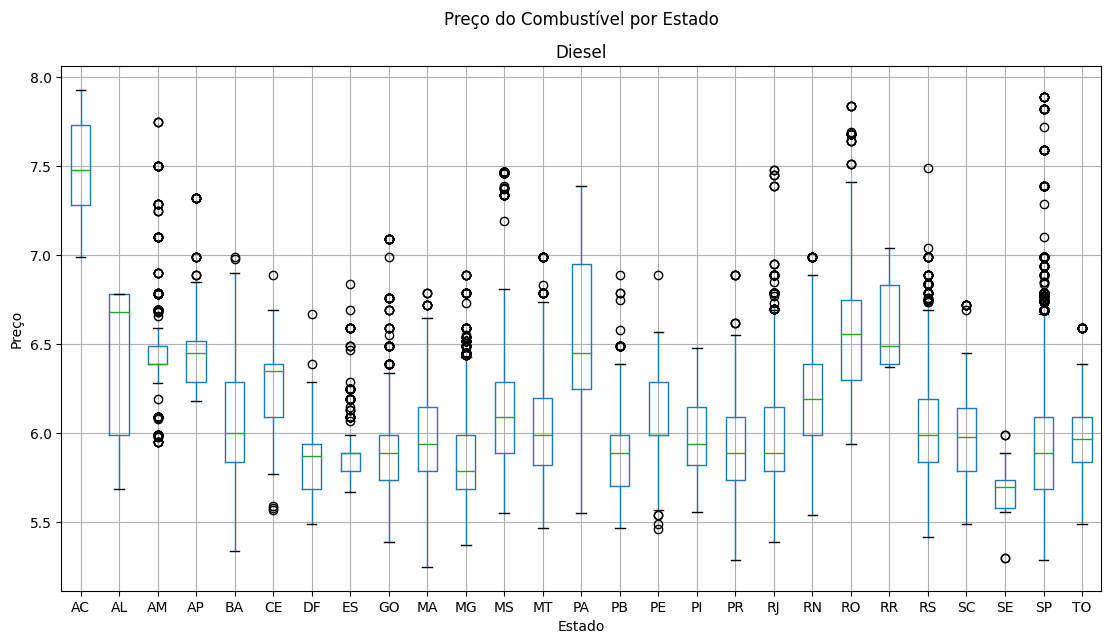

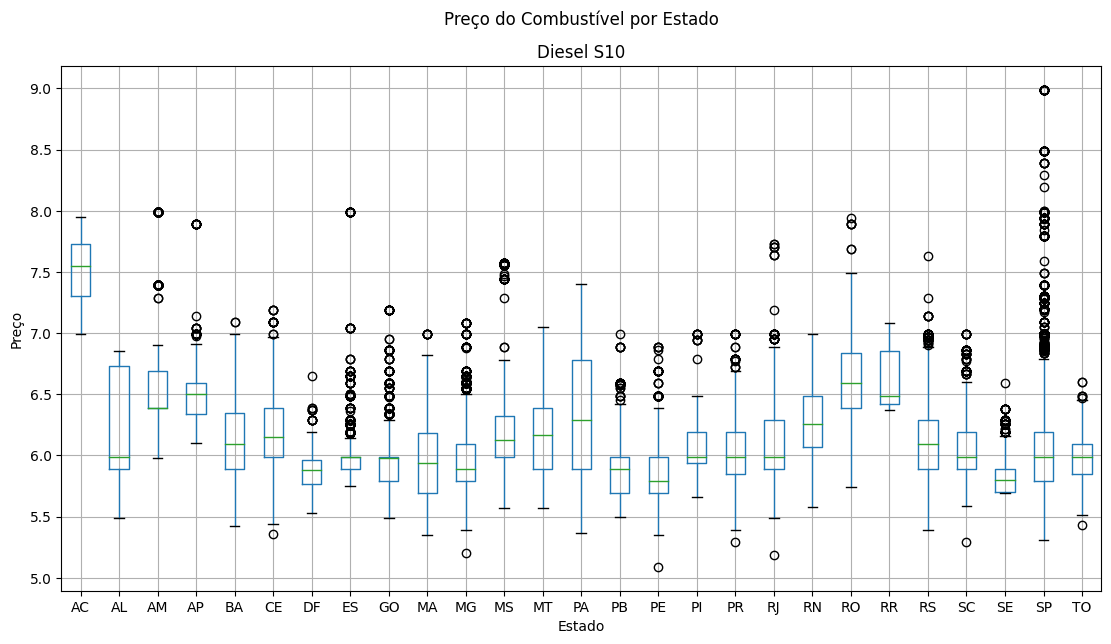

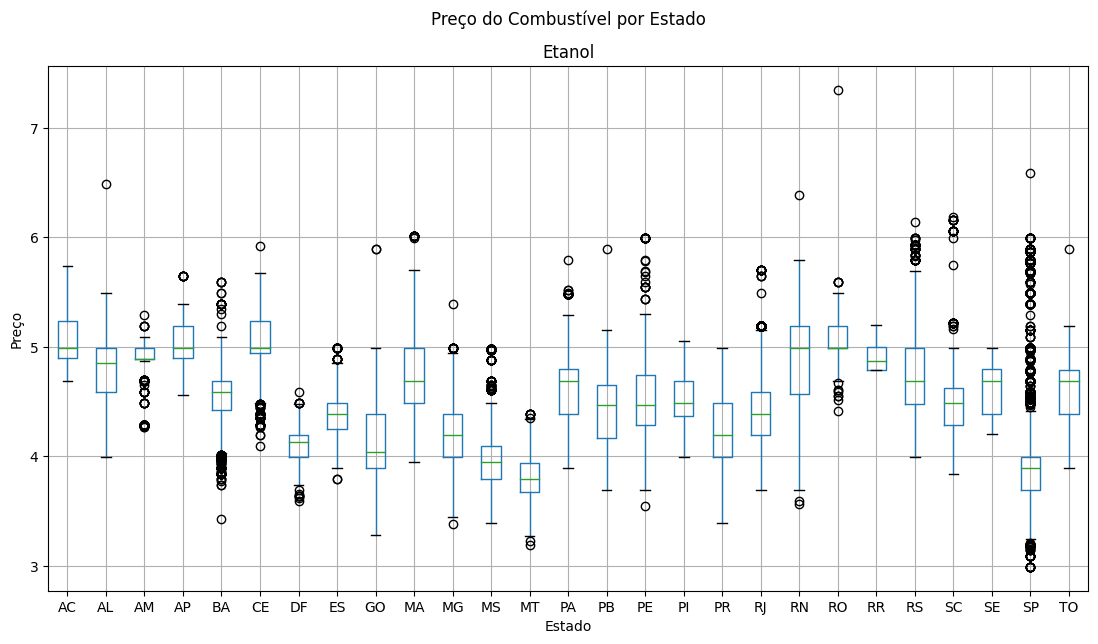

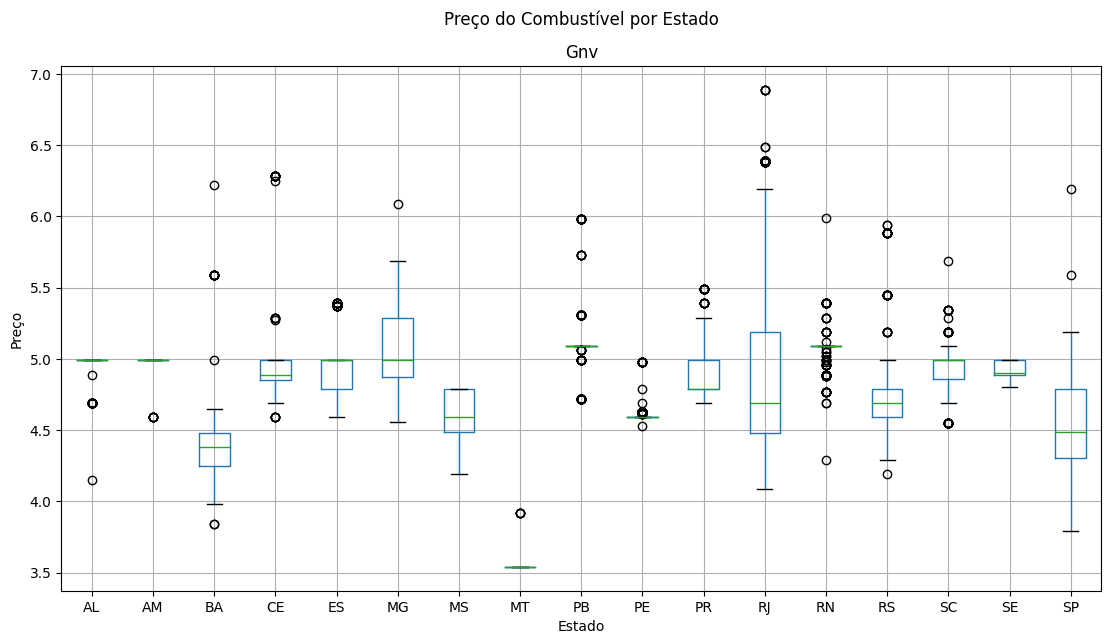

In [11]:
lista_chaves_produtos = list(produtos.keys())
for p in lista_chaves_produtos:
    produtos[p].boxplot(by='estado', figsize=(13,7))
    plt.suptitle('Preço do Combustível por Estado')
    plt.title(p.replace('_',' ').title())
    plt.ylabel('Preço')
    plt.xlabel('Estado')
    plt.show()

## 5.4. Identificando os outliers

Inclusão de uma coluna chamada 'outlier' em cada dataframe com o objetivo de marcar com 'True' os dados discrepantes sem removê-los dos dataframes, permitindo analisá-los estatisticamente:

In [12]:
for df in produtos.values():
    df['outlier'] = False

Aplicando o valor 'True' na coluna 'outlier' para os preços discrepantes dos dataframes em cada estado:

In [153]:
for df in produtos.values():
    estados = list(df['estado'].unique())
    for estado in estados:
        quartis = df.query('estado == @estado')['preco'].quantile([.25, .75]).to_list()
        iiq = quartis[1] - quartis[0]
        ls = quartis[1] + (1.5 * iiq)
        li = quartis[0] - (1.5 * iiq)
        df.loc[(df['estado'] == estado) & ((df['preco'] > ls) | (df['preco'] < li)), 'outlier'] = True


Proporção de outliers por produto:

In [201]:
for p in produtos.keys():
    discrepantes = int(produtos[p].groupby('outlier')[['preco']].count().T[True].values)
    ndiscrepantes = int(produtos[p].groupby('outlier')[['preco']].count().T[False].values)
    print(f'{(discrepantes / ndiscrepantes) * 100 : .2f}% em {p.title().replace("_", " ")}')

 3.35% em Gasolina
 2.56% em Gasolina Aditivada
 3.07% em Diesel
 2.65% em Diesel S10
 2.62% em Etanol
 7.54% em Gnv


## 5.5. Removendo os outliers

Criação de um novo dataframe, apenas com os valores não discrepantes:

In [206]:
produtos_sout = {}
for p in produtos.keys():
    df = produtos[p]
    produtos_sout[p] = df[df['outlier'] == False].drop('outlier', axis=1)

# 6. Preço médio por estado para cada produto

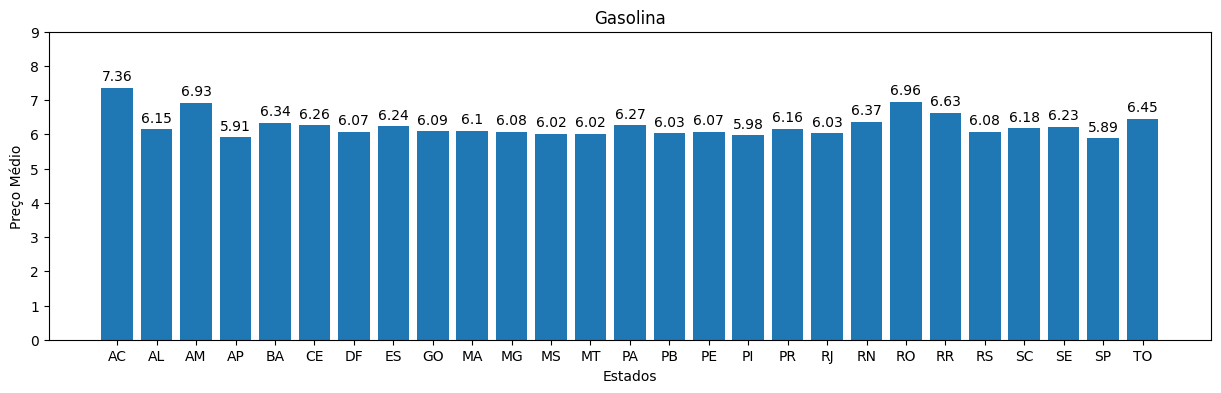

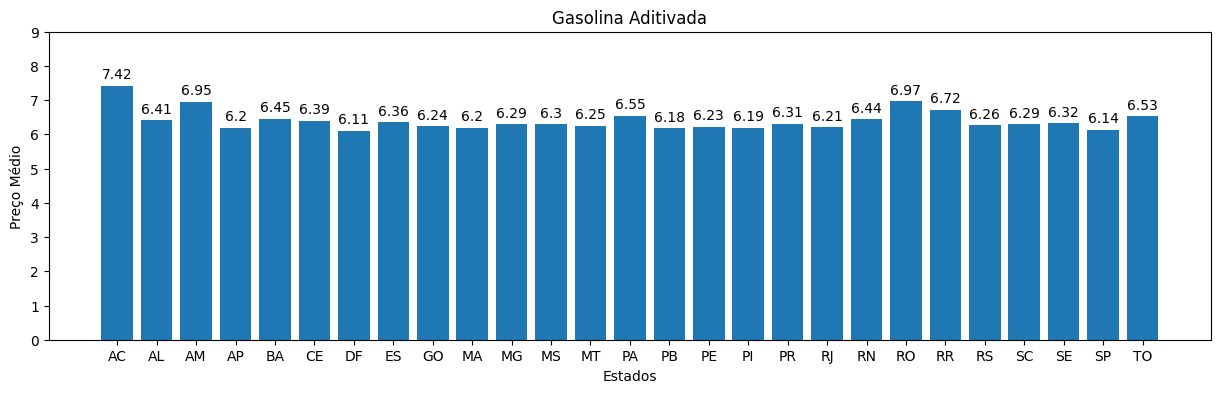

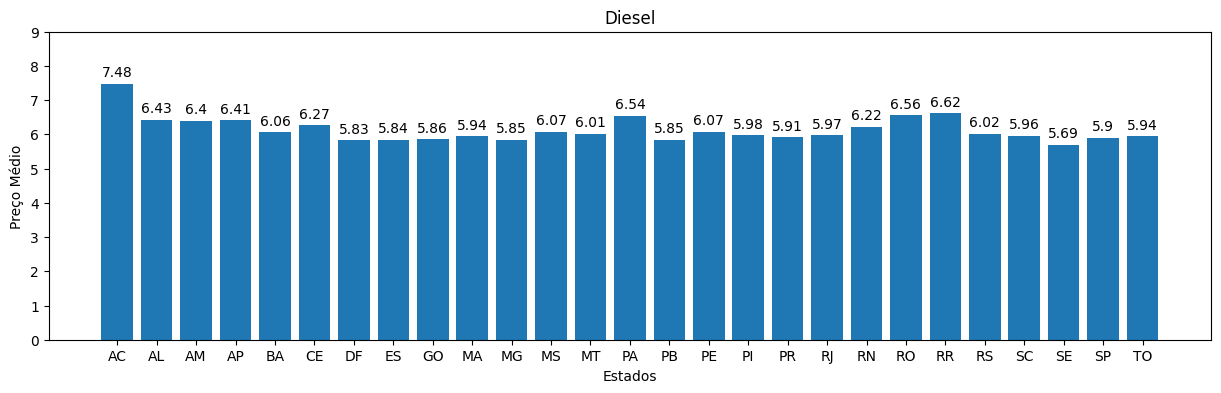

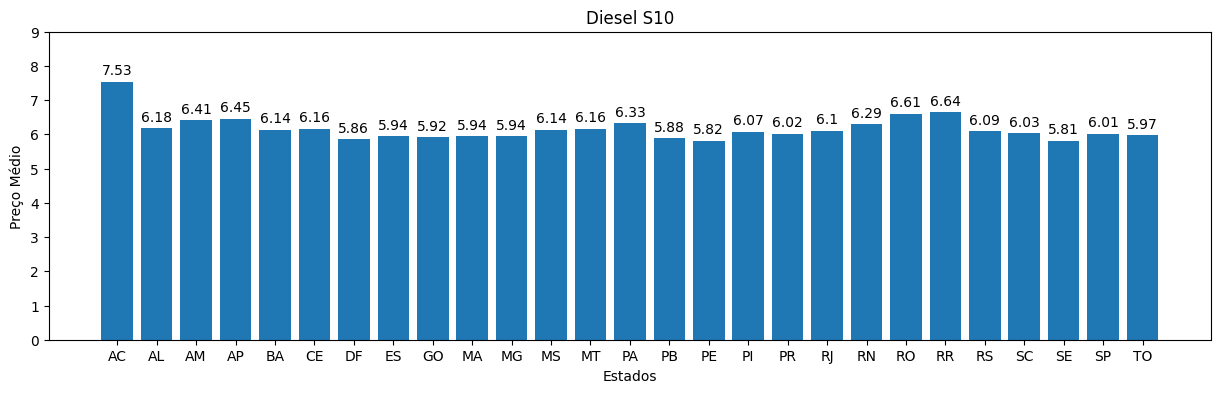

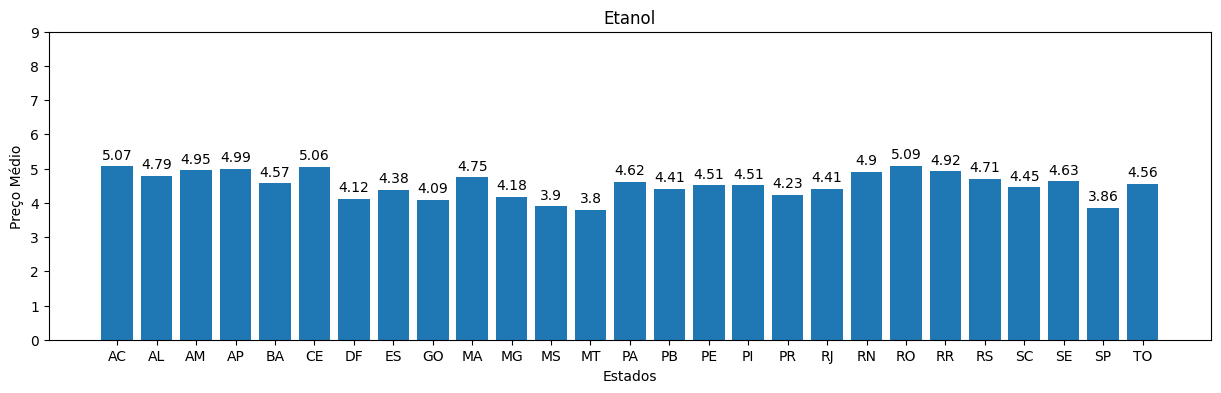

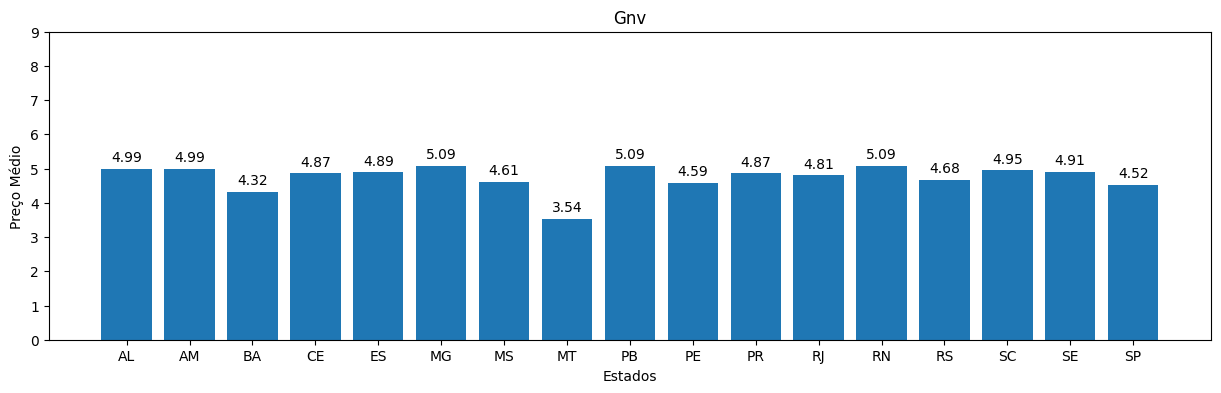

In [268]:
for p in produtos_sout.keys():
    produto = p.title().replace('_', ' ')
    df = produtos_sout[p].groupby('estado').mean('preco')
    df['preco'] = df['preco'].apply(lambda x: round(x, 2))
    colunas = df.index.to_list()
    valores = df.preco.to_list()
    fig, ax = plt.subplots(figsize=(15,4))
    barras = ax.bar(colunas, valores)
    ax.set_title(produto)
    ax.set_ybound(0,9)
    ax.set_ylabel('Preço Médio')
    ax.set_xlabel('Estados')
    for barra in barras:
        height = barra.get_height()
        ax.annotate('{}'.format(height),
                    xy=(barra.get_x() + barra.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

# 7. Município com menor preço em Minas Gerais

In [294]:
for p in produtos_sout.keys():
    df = produtos_sout[p]
    mg = df[df['estado'] == 'MG']
    menor_preco = mg.min()['preco']
    cidades = mg[mg['preco'] == menor_preco]
    print('==============================================')
    print(p.title().replace('_',' '))
    print('----------------------------------------------')
    print(cidades.drop_duplicates('municipio').drop('estado', axis=1))

Gasolina
----------------------------------------------
            municipio  preco
160   POCOS DE CALDAS   5.29
1575          GUAXUPE   5.29
3516           LAVRAS   5.29
Gasolina Aditivada
----------------------------------------------
              municipio  preco
118     POCOS DE CALDAS   5.49
123    SAO JOAO DEL REI   5.49
1611            UBERABA   5.49
2108          ITUIUTABA   5.49
3175           VARGINHA   5.49
12157            PASSOS   5.49
Diesel
----------------------------------------------
      municipio  preco
612  UBERLANDIA   5.37
Diesel S10
----------------------------------------------
     municipio  preco
2776      UNAI   5.39
Etanol
----------------------------------------------
     municipio  preco
2091   UBERABA   3.45
Gnv
----------------------------------------------
        municipio  preco
160  JUIZ DE FORA   4.56
